In [329]:
import pandas as pd
# from fbprophet import Prophet
import pandas
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import numpy as np
from praveganb.pravega_stream import UnindexedStream
import seaborn as sns
import pytz
import grpc
import imp
import pravega.grpc_gateway as pravega
from datetime import datetime, timedelta
import json
%matplotlib inline

# Setup the Connection with pravega and Read System Usage

In [330]:
gateway = '10.243.54.104:80'
scope = 'alerts'
stream = 'snmp-enriched'

In [331]:
pravega_channel = grpc.insecure_channel(gateway, options=[
        ('grpc.max_receive_message_length', 9*1024*1024),
    ])
pravega_client = pravega.grpc.PravegaGatewayStub(pravega_channel)

In [332]:
snmpdata = UnindexedStream(scope='alerts', stream='snmp-enriched', pravega_client=pravega_client)
events = snmpdata.read_events_from_stream(stop_at_tail=True)

In [333]:
df = pd.DataFrame(list(events))

In [334]:
df['timeStrStamp'] = pandas.to_datetime(df['receivedTimestamp'],unit="ms",utc=True)

In [335]:
minTime = (datetime.now() - timedelta(hours = 3)).timestamp() * 1000

In [336]:
df = df[(df.receivedTimestamp > minTime )]

# Notify Level for Past Two Hours

In [337]:
df.notifyLevel.value_counts()

0    421
5    218
Name: notifyLevel, dtype: int64

# Notify Type and Message Breakdown By Device for Past Two Hours

In [338]:
df[['deviceMibModule','notifyLevel', 'notifyMessage']].value_counts()

deviceMibModule  notifyLevel  notifyMessage                                        
ISILON-TRAP-MIB  0            SW_CELOG_HEARTBEAT                                       258
SCALEIO-MIB      5            System.Credentials.MDM_CREDENTIALS_ARE_NOT_CONFIGURED    218
ISILON-TRAP-MIB  0            SW_MOUNTD_CLIENT_MOUNT_FAILED                            126
                              SW_CERTIFICATE_EXPIRED                                    30
                              SW_TEST_EVENT                                              6
                              SW_CLUSTER_MONTHLY_STATUS                                  1
dtype: int64

# Notify Message for Past Two Hours

In [339]:
mess = df.notifyMessage.value_counts()

<AxesSubplot:>

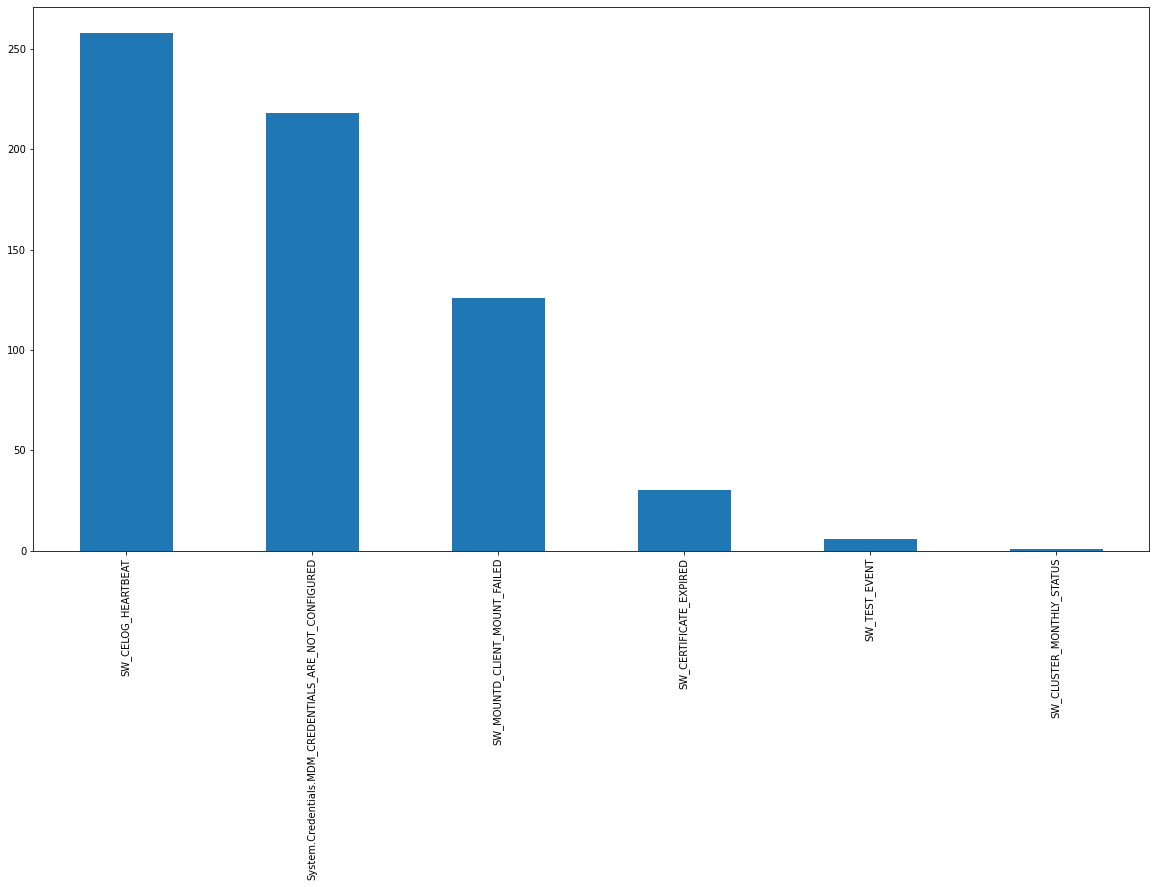

In [340]:
mess.plot(kind='bar', figsize=(20,10))

# Device Type for Past Two Hours

In [341]:
dev = df.deviceMibModule.value_counts()

<AxesSubplot:>

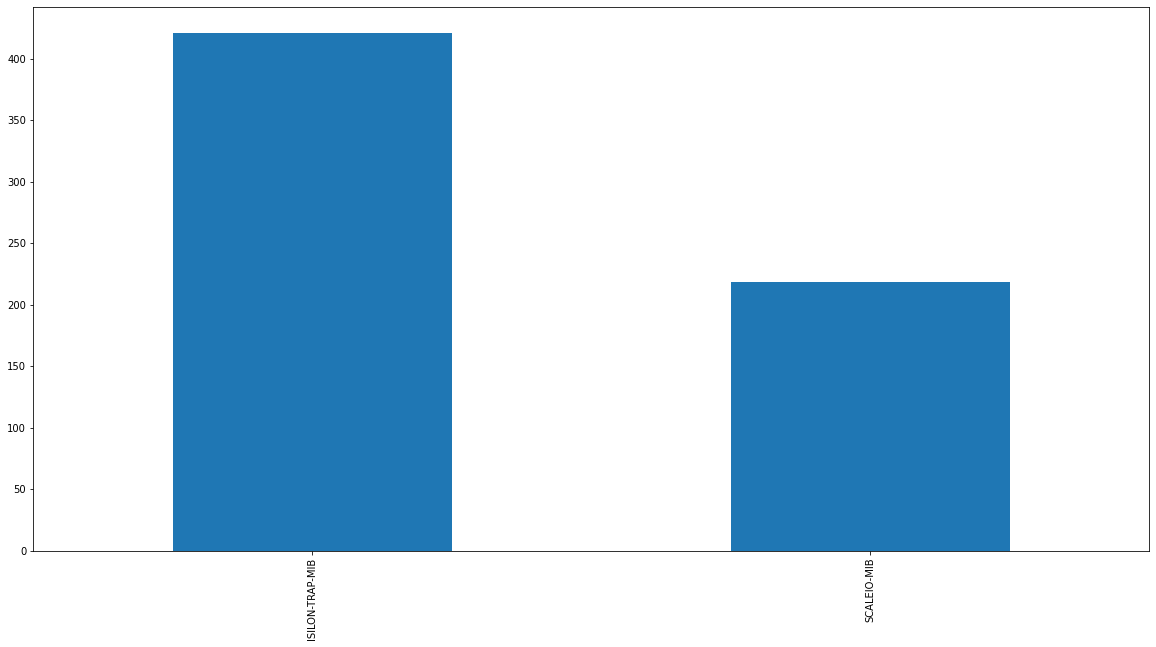

In [342]:
dev.plot(kind='bar', figsize=(20,10))

# SNMP Trap Type  Breakdown by Device for Past Two Hours

In [343]:
expand_df = pd.json_normalize(df['trap'], meta=['receivedTimestamp'])


In [344]:
df = df.join(expand_df).drop('trap', axis=1)

In [345]:
df[['deviceMibModule','type']].value_counts()

Series([], dtype: int64)

# Counter Failure Message By Specific Name

In [346]:
failure_msg = 'SW_CELOG_HEARTBEAT'

In [347]:
len(df[df['notifyMessage']==failure_msg])

258